_ASSIGNMENT-2 PRATHAM SUNKAD ME21B145_

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

**Defining functions**

In [2]:
def read_data(filename):
    data = pd.read_csv(filename, header=None)
    data_array = data.iloc[:, :].values.T
    return data_array

Bernoulli Mixture Model Functions

In [3]:
def initialize_mixture_params(data, K):
    p_array = np.random.rand(data.shape[0], K)
    pi_array = np.random.dirichlet(np.ones(K), size=1)[0]
    return p_array, pi_array

In [4]:
def e_step(data, p_array, pi_array):
    N = data.shape[1]
    K = p_array.shape[1]
    lambda_array = np.zeros((N, K))
    for i in range(N):
        for j in range(K):
            lambda_array[i, j] = pi_array[j] * np.prod(p_array[:, j] ** data[:, i] * (1 - p_array[:, j]) ** (1 - data[:, i]))
        lambda_array[i] /= np.sum(lambda_array[i])
    return lambda_array

In [5]:
def m_step(data, lambda_array):
    N = data.shape[1]
    K = lambda_array.shape[1]
    pi_array = np.mean(lambda_array, axis=0)
    p_array = np.zeros((data.shape[0], K))
    for j in range(K):
        p_array[:, j] = np.sum(lambda_array[:, j] * data, axis=1) / np.sum(lambda_array[:, j])
    return p_array, pi_array

In [6]:
def log_likelihood(data, p_array, pi_array):
    N = data.shape[1]
    K = p_array.shape[1]
    log_l = 0
    for i in range(N):
        likelihood = 0
        for j in range(K):
            likelihood += pi_array[j] * np.prod(p_array[:, j] ** data[:, i] * (1 - p_array[:, j]) ** (1 - data[:, i]))
        log_l += np.log(likelihood)
    return log_l

In [123]:
def em_algorithm(dataset, K, iterations):
    log_l = np.zeros(iterations)
    iter = np.zeros(iterations)
    for ini in range(100):
        p_array, pi_array = initialize_mixture_params(dataset, K)
        for i in range(iterations):
            log_l[i]+=log_likelihood(dataset, p_array, pi_array)
            iter[i] = i
            lambda_array = e_step(dataset, p_array, pi_array)
            p_array, pi_array = m_step(dataset, lambda_array)
    log_l /= 100
    return p_array, pi_array, lambda_array, log_l, iter

Multivariate Gaussian Mixture Model Functions

In [72]:
def initialize_mixture_params_gaussian(data, K):
    mu_array = np.random.rand(data.shape[0], K)
    sigma_array = np.zeros((data.shape[0], data.shape[0], K))
    for k in range(K):
        # sigma_array[:, :, k] = mu_array[:, k] @ mu_array[:, k].T
        sigma_array[:,:,k] = np.eye(data.shape[0])/10
    pi_array = np.random.dirichlet(np.ones(K), size=1)[0]
    return mu_array, sigma_array, pi_array

In [151]:
def e_step_gaussian(data, mu_array, sigma_array, pi_array):
    N = data.shape[1]
    K = mu_array.shape[1]
    d = data.shape[0]
    lambda_array = np.random.rand(N, K)
    for i in range(N):
        for j in range(K):
            if(np.linalg.det(sigma_array[:, :, j]) == 0):
                sigma_array[:, :, j] += 0.04 * np.eye(d)
            lambda_array[i, j] = pi_array[j]*((2 * np.pi)**(-d/2) * (np.linalg.det(sigma_array[:,:, j]))**-0.5) * np.exp(-0.5 * ((data[:, i] - mu_array[:, j]).T @ np.linalg.inv(sigma_array[:, :, j]) @ (data[:, i] - mu_array[:, j])))
        lambda_array[i] /= np.sum(lambda_array[i])
    return lambda_array

In [150]:
def m_step_gaussian(data, lambda_array):
    N = data.shape[1]
    K = lambda_array.shape[1]
    pi_array = np.mean(lambda_array, axis=0)
    mu_array = np.zeros((data.shape[0], K))
    sigma_array = np.zeros((data.shape[0], data.shape[0], K))
    for j in range(K):
        mu_array[:, j] = np.sum(lambda_array[:, j].reshape(-1,1) * data.T, axis=0) / np.sum(lambda_array[:, j])
        for i in range(N):
            sigma_array[:,:, j] += lambda_array[i, j] * ((data[:,i] - mu_array[:, j]) @ (data[:,i] - mu_array[:, j]).T) / np.sum(lambda_array[:, j])
    return mu_array, sigma_array, pi_array

In [148]:
def log_likelihood_gaussian(data, mu_array, sigma_array, pi_array):
    N = data.shape[1]
    K = mu_array.shape[1]
    d = data.shape[0]
    log_l = 0
    for i in range(N):
        likelihood = 0
        for j in range(K):
            if(np.linalg.det(sigma_array[:, :, j]) == 0):
                sigma_array[:, :, j] += 0.04 * np.eye(d)
            likelihood += pi_array[j]*((2 * np.pi)**(-d/2) * (np.linalg.det(sigma_array[:,:, j]))**-0.5) * np.exp(-0.5 * ((data[:, i] - mu_array[:, j]).T @ np.linalg.inv(sigma_array[:, :, j]) @ (data[:, i] - mu_array[:, j])))
        log_l += np.log(likelihood)
    return log_l

In [149]:
def em_algorithm_gaussian(dataset, K, iterations):
    log_l = np.zeros(iterations)
    iter = np.zeros(iterations)
    for ini in range(100):
        mu_array, sigma_array, pi_array = initialize_mixture_params_gaussian(dataset, K)
        for i in range(iterations):
            log_l[i]+=log_likelihood_gaussian(dataset, mu_array, sigma_array, pi_array)
            iter[i] = i
            lambda_array = e_step_gaussian(dataset, mu_array, sigma_array, pi_array)
            mu_array, sigma_array, pi_array = m_step_gaussian(dataset, lambda_array)
    
    log_l /= 100
    return mu_array, sigma_array, pi_array, lambda_array, log_l, iter

K-Means functions

In [13]:
def random_initialize(dataset, k):
    z_array = np.zeros(len(dataset))
    for i in range(len(dataset)):
        z_array[i] = int(np.random.randint(1, k+1))
    return z_array

In [14]:
def cal_mean(dataset, z_array, k):
    d = dataset.shape[1]
    mean_array = np.zeros((k, d))
    count_z = np.zeros(k)
    for z in z_array:
        count_z[z-1]+=1
        
    for i in range(len(z_array)):
        for j in range(d):
            mean_array[z_array[i]-1][j] += dataset[i][j]/count_z[z_array[i]-1]

        
    return mean_array

In [15]:
def cal_error(dataset, mean_array, z_array):
    error = 0
    for i in range(len(dataset)):
        error += np.linalg.norm(dataset[i]-mean_array[z_array[i]-1])**2
    return error

In [16]:
def reassign(dataset, mean_array, z_array):
    for i in range(len(dataset)):
        for j in range(len(mean_array)):
            distance = np.linalg.norm(dataset[i]-mean_array[j])**2
            if j == 0:
                min_distance = distance
                z = j+1
                continue
            if distance < min_distance:
                min_distance = distance
                z = j+1
                
        z_array[i] = z
    return z_array

In [17]:
def kmeans(dataset, k):
    z_array = np.array(random_initialize(dataset, k) ,dtype=int)
    error_array = []
    iter_array = []
    mean_array = cal_mean(dataset, z_array, k)
    error = cal_error(dataset, mean_array, z_array)
    iterations = 0
    while True:
        error_array.append(error)
        iter_array.append(iterations)
        z_array = reassign(dataset, mean_array, z_array)
        mean_array = cal_mean(dataset, z_array, k)
        new_error = cal_error(dataset, mean_array, z_array)
        if new_error == error:
            break
        error = new_error
        iterations += 1
    return error_array, iter_array

In [18]:
def compare_kmeans_em(dataset_kmeans, lam_array, k):
    N = lam_array.shape[0]
    z_array = np.zeros(N)
    for i in range(N):
        cluster = np.argmax(lam_array[i])+1
        z_array[i] = cluster
    z_array = np.array(z_array, dtype=int)
    mean_array = cal_mean(dataset_kmeans, z_array, k)
    error = cal_error(dataset_kmeans, mean_array, z_array)
    return error

Main Code : 
Initializing the dataset

In [19]:
filename = 'A2Q1.csv'
dataset = read_data(filename)
dataset.shape

(50, 400)

In [20]:
dataset_kmeans = dataset.T
dataset_kmeans.shape

(400, 50)

Plotting Log Likely for Bernoulli Mixture Model

In [140]:
K = 4
iterations = 50

In [141]:
p_array, pi_array, lambda_array, log_l, iter = em_algorithm(dataset, K, iterations)

In [142]:
pi_array

array([0.01519687, 0.59149143, 0.14259815, 0.25071355])

In [143]:
p_array

array([[0.00000000e+000, 4.49172208e-002, 2.69511580e-001,
        8.97438348e-002],
       [3.31602689e-001, 9.97682248e-002, 9.42643748e-002,
        5.98559667e-002],
       [4.94063847e-001, 7.87892171e-002, 1.81549560e-001,
        1.09686924e-001],
       [1.30748203e-016, 1.15822544e-001, 2.79942320e-002,
        4.98578232e-002],
       [0.00000000e+000, 5.85532766e-002, 2.12947598e-001,
        1.19659686e-001],
       [0.00000000e+000, 1.52157842e-001, 3.33980301e-011,
        9.97151545e-002],
       [1.65319160e-001, 8.59965497e-002, 2.16221743e-001,
        1.12832446e-001],
       [0.00000000e+000, 4.22219170e-002, 1.93031545e-001,
        1.19659094e-001],
       [2.03731019e-158, 7.68389296e-002, 1.37126953e-001,
        9.97009600e-002],
       [3.30427857e-001, 1.17647482e-001, 1.95591803e-001,
        7.97724108e-002],
       [1.83352605e-001, 9.51287866e-002, 9.48718744e-002,
        1.59214365e-001],
       [1.64947968e-001, 1.28388848e-001, 1.33609071e-001,
      

In [144]:
lambda_array

array([[0.00000000e+00, 4.40300188e-10, 4.60598575e-30, 1.00000000e+00],
       [0.00000000e+00, 2.01768649e-10, 9.10339653e-30, 1.00000000e+00],
       [0.00000000e+00, 2.84160456e-08, 1.52271026e-25, 9.99999972e-01],
       ...,
       [0.00000000e+00, 9.99999999e-01, 7.75335144e-11, 8.38315948e-10],
       [0.00000000e+00, 1.00000000e+00, 3.38779806e-10, 2.01965397e-12],
       [0.00000000e+00, 9.99999998e-01, 1.25394482e-12, 1.83266214e-09]])

In [145]:
log_l, iter

(array([-17892.39723087,  -7342.06602295,  -6961.51058169,  -6790.48402964,
         -6718.86544522,  -6685.0771481 ,  -6668.75153439,  -6659.37783457,
         -6654.09620046,  -6651.67231862,  -6650.18492104,  -6648.87606775,
         -6647.78855849,  -6646.82906406,  -6646.10093609,  -6645.49896125,
         -6644.95771226,  -6644.52242973,  -6644.16011043,  -6643.86581626,
         -6643.55659393,  -6643.22277555,  -6642.92018609,  -6642.63693139,
         -6642.41987869,  -6642.22593405,  -6641.9936013 ,  -6641.66078234,
         -6641.302154  ,  -6641.00488075,  -6640.81689558,  -6640.6590066 ,
         -6640.50264908,  -6640.34667296,  -6640.21401388,  -6640.02700292,
         -6639.90375072,  -6639.83267818,  -6639.7361996 ,  -6639.42388192,
         -6639.10724763,  -6638.41246126,  -6638.10418563,  -6638.04195583,
         -6637.99650425,  -6637.95510447,  -6637.91542199,  -6637.86886219,
         -6637.42858093,  -6636.69712183]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  

Text(0, 0.5, 'Log likelihood')

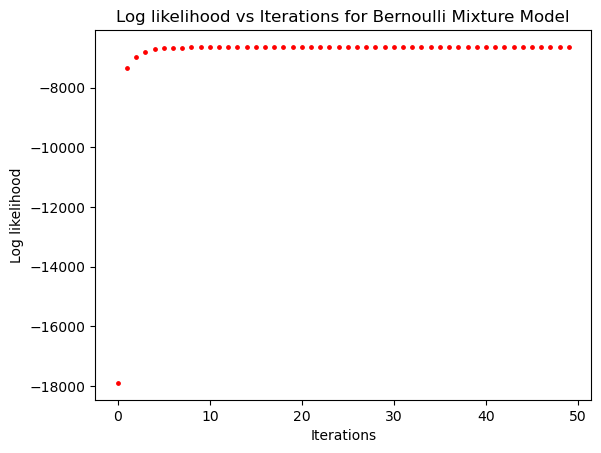

In [146]:
plt.scatter(iter, log_l, s=6, c='r', marker='o')
plt.title('Log likelihood vs Iterations for Bernoulli Mixture Model')
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

Plotting Log - Likelihood for Multivariate Gaussian distribution

In [152]:
K = 4
iterations = 20

In [153]:
mu_gauss, sigma_gauss, pi_gauss, lam_gauss, log, it = em_algorithm_gaussian(dataset, K, iterations)

In [154]:
mu_gauss

array([[8.91308339e-02, 5.22885895e-02, 9.90638175e-02, 3.47648280e-02],
       [5.94205559e-02, 1.84303426e-01, 6.93387763e-02, 2.74830455e-01],
       [1.08937686e-01, 1.84305104e-01, 9.06657737e-02, 1.37068406e-01],
       [4.95171300e-02, 7.88955464e-02, 1.03686220e-01, 6.66534764e-02],
       [1.18841112e-01, 2.63330872e-02, 9.92636037e-02, 6.74855237e-02],
       [9.90342599e-02, 1.84292598e-01, 1.16333607e-01, 6.86917090e-02],
       [1.18595087e-01, 1.05309241e-01, 1.03672353e-01, 1.72014540e-01],
       [1.18841112e-01, 1.84293896e-01, 5.59525751e-02, 3.48547355e-02],
       [9.90342599e-02, 5.22744513e-02, 9.90577113e-02, 3.48329473e-02],
       [7.92274079e-02, 7.88986782e-02, 1.33686537e-01, 2.41849267e-01],
       [1.58454815e-01, 7.89865304e-02, 9.03865005e-02, 1.74162900e-01],
       [1.28744538e-01, 9.99981023e-01, 8.41161440e-05, 3.48475782e-02],
       [1.28498513e-01, 9.47342947e-01, 9.05308941e-01, 8.95503686e-01],
       [8.51448610e-01, 8.42030714e-01, 8.83787640e

In [155]:
log

array([-25017.12072013, -12581.0472925 , -10220.30143924,  -9905.79133664,
        -9856.7418943 ,  -9832.29434184,  -9814.60352259,  -9800.7483562 ,
        -9789.21434047,  -9779.12924051,  -9771.11268221,  -9764.73718286,
        -9759.19029028,  -9754.44324221,  -9749.93364167,  -9745.65464726,
        -9741.93458522,  -9738.44685848,  -9735.30642721,  -9732.17039165])

Text(0, 0.5, 'Log likelihood')

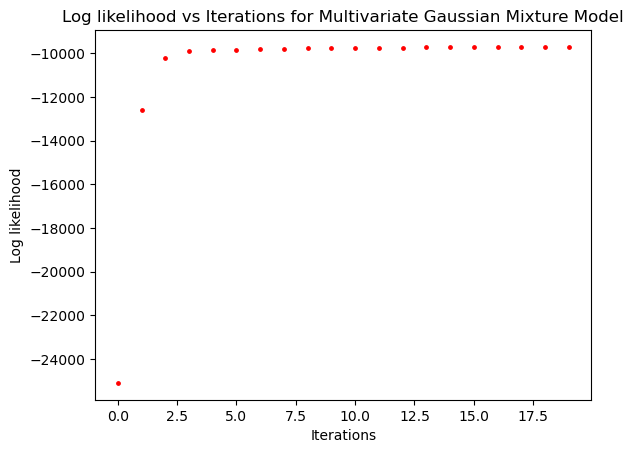

In [156]:
plt.scatter(it_3, log_3, s=6, c='r', marker='o')
plt.title('Log likelihood vs Iterations for Multivariate Gaussian Mixture Model')
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

K-Means

In [157]:
K = 4

In [158]:
error_array, iter_array = kmeans(dataset_kmeans, K)

In [159]:
error_array

[2279.4257454200547,
 1800.7626859891566,
 1752.7985308317893,
 1747.7056101758249,
 1747.0040084232303,
 1746.3863170658274,
 1746.040076161463,
 1745.8100761614612,
 1745.7006277334424,
 1745.564726699096]

Text(0, 0.5, 'Error')

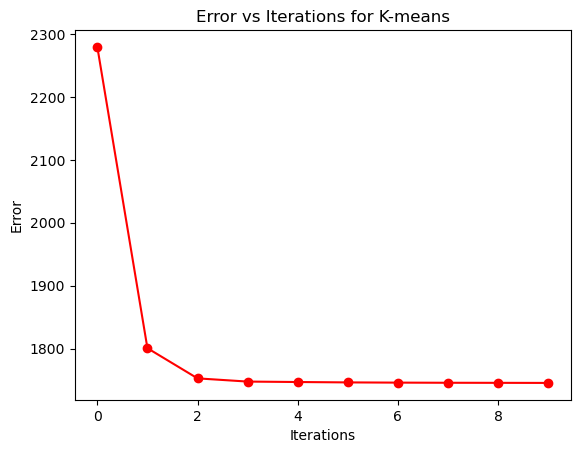

In [160]:
plt.plot(iter_array, error_array, '-o', color='r')
plt.title('Error vs Iterations for K-means')
plt.xlabel('Iterations')
plt.ylabel('Error')

Comparing K-means, BMM and GMM using Hard Clustering

In [162]:
error_kmeans = error_array[len(error_array)-1]
error_bmm = compare_kmeans_em(dataset_kmeans, lambda_array, K)
error_gmm = compare_kmeans_em(dataset_kmeans, lam_gauss, K)

In [164]:
error_kmeans, error_bmm, error_gmm

(1745.564726699096, 1763.4333333333338, 1734.0502506693504)

GMM has the least value of the objective function

Trying to plot the images

In [223]:
dataset_images = dataset.reshape(10,5,400)

In [224]:
dataset_images[:,:,0].shape

(10, 5)

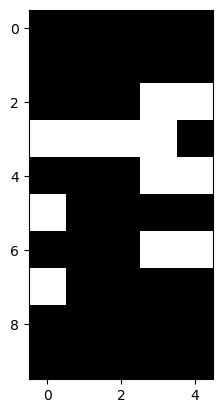

In [225]:
plt.imshow(dataset_images[:,:,0], cmap='gray')

In [234]:
mean_image = np.mean(dataset, axis = 1)

In [236]:
mean_image = mean_image.reshape(10, 5)

In [238]:
mean_image

array([[0.0875, 0.0925, 0.1075, 0.085 , 0.095 ],
       [0.115 , 0.1125, 0.0825, 0.09  , 0.1225],
       [0.1125, 0.13  , 0.7125, 0.8725, 0.9   ],
       [0.9175, 0.885 , 0.8875, 0.915 , 0.08  ],
       [0.0975, 0.12  , 0.685 , 0.275 , 0.86  ],
       [0.2975, 0.7   , 0.0775, 0.1025, 0.105 ],
       [0.0825, 0.1275, 0.685 , 0.89  , 0.8875],
       [0.2975, 0.6775, 0.7225, 0.7   , 0.12  ],
       [0.0825, 0.1   , 0.075 , 0.115 , 0.09  ],
       [0.12  , 0.1   , 0.085 , 0.0825, 0.0925]])

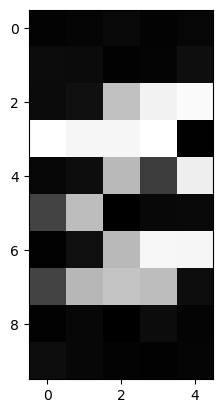

In [237]:
plt.imshow(mean_image, cmap='gray')  